In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


In [ ]:
df=pd.read_csv('datos_modelo.csv')
df=df[['Income','Desired_Savings','Dependents','Occupation','City_Tier','Gasto_Fijo','Gastos_variables','Desired_Savings']]
df

,Income,Age,Dependents,Occupation,City_Tier,Gasto_Fijo,Gastos_variables,Desired_Savings
0,44637.25,49,0,Self_Employed,Tier_1,24893.40,8478.21,6200.54
1,26858.60,34,2,Retired,Tier_2,12154.42,5027.35,1923.18
2,50367.61,35,1,Student,Tier_3,22451.59,9412.47,7050.36
3,101455.60,21,0,Self_Employed,Tier_3,41904.04,21124.17,16694.97
4,24875.28,52,4,Professional,Tier_2,11366.68,4130.32,1874.10
...,...,...,...,...,...,...,...,...
19995,40913.47,51,4,Self_Employed,Tier_1,24323.79,7722.50,1163.32
19996,90295.77,21,1,Student,Tier_2,43865.50,15705.09,10613.59
19997,40604.57,30,1,Professional,Tier_2,22091.78,8155.27,2267.91
19998,118157.82,27,2,Professional,Tier_1,71061.02,24147.20,10603.68


In [6]:
X=df[['Income','Age','Dependents','Occupation','City_Tier','Gasto_Fijo','Gastos_variables']]
y=df['Desired_Savings']
num_features=['Income','Age','Dependents','Gasto_Fijo','Gastos_variables']
cat_features=['Occupation','City_Tier']

In [7]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Escalado estándar para las columnas numéricas
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding para categóricas
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Age',
                                                   'Dependents', 'Gasto_Fijo',
                                                   'Gastos_variables']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Occupation',
                                                   'City_Tier'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [15]:
y_pred = model.predict(X_test)

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 904.30
Mean Squared Error (MSE): 9327790.86
Root Mean Squared Error (RMSE): 3054.14
R2 Score: 0.87


In [18]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


In [19]:
# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Mejor MAE: {mae_best:.2f}")
print(f"Mejor R2: {r2_best:.2f}")

Mejor MAE: 884.45
Mejor R2: 0.87


In [20]:
# 8. Guardar el modelo entrenado
import joblib
joblib.dump(best_model, 'modelo_ahorros.pkl')
print("Modelo guardado como 'modelo_ahorros.pkl'.")

Modelo guardado como 'modelo_ahorros.pkl'.


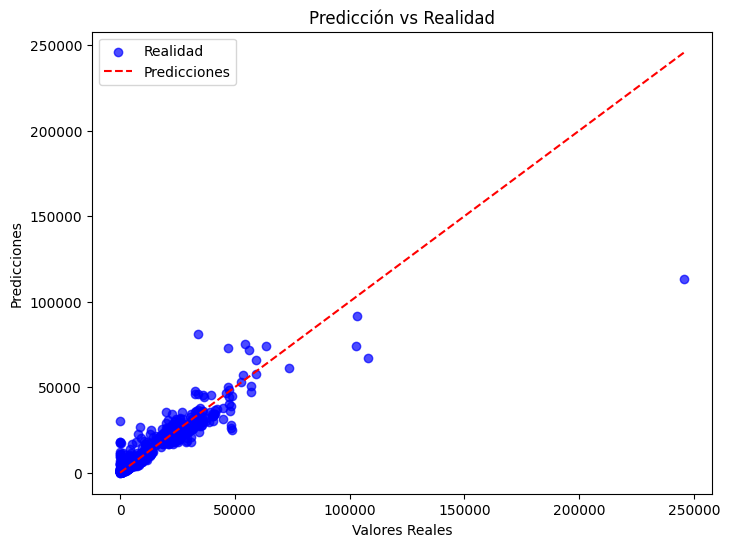

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicción vs Realidad")
plt.legend(["Realidad", "Predicciones"])
plt.show()

In [24]:
# Crear una tabla de comparación entre valores reales y predicciones
comparison_df = pd.DataFrame({
    'Valores Reales': y_test,
    'Predicciones': y_pred_best
})

# Opcional: Agregar una columna con el error absoluto
comparison_df['Error Absoluto'] = abs(comparison_df['Valores Reales'] - comparison_df['Predicciones'])

# Mostrar las primeras filas de la tabla
(comparison_df.head())

,Valores Reales,Predicciones,Error Absoluto
10650,1577.91,1890.976842,313.066842
2041,1972.33,1637.588150,334.741850
8668,4169.77,5043.723919,873.953919
1114,2802.13,2579.127652,223.002348
13902,2806.26,2146.321522,659.938478


In [30]:
df['Desired_Savings'].describe()

count     20000.000000
mean       4982.878372
std        7733.468198
min           0.000000
25%        1224.932500
50%        2155.355000
75%        6216.307500
max      245504.490000
Name: Desired_Savings, dtype: float64

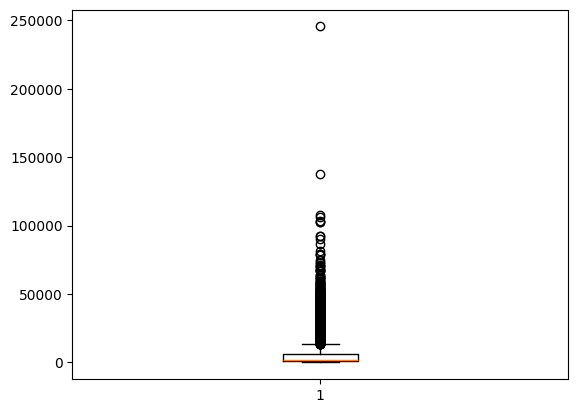

In [32]:
plt.boxplot(df['Desired_Savings'])
plt.show()

In [35]:
quartiles = df['Desired_Savings'].quantile([0.25, 0.5, 0.75])

# Contar datos en cada cuartil
q1 = df[df['Desired_Savings'] <= quartiles[0.25]]
q2 = df[(df['Desired_Savings'] > quartiles[0.25]) & (df['Desired_Savings'] <= quartiles[0.5])]
q3 = df[(df['Desired_Savings'] > quartiles[0.5]) & (df['Desired_Savings'] <= quartiles[0.75])]
q4 = df[df['Desired_Savings'] > quartiles[0.75]]

# Cantidad de datos por cuartil
quartile_counts = {
    "Q1 (<= 25%)": len(q1),
    "Q2 (25% - 50%)": len(q2),
    "Q3 (50% - 75%)": len(q3),
    "Q4 (> 75%)": len(q4),
}

quartiles, quartile_counts

(0.25    1224.9325
 0.50    2155.3550
 0.75    6216.3075
 Name: Desired_Savings, dtype: float64,
 {'Q1 (<= 25%)': 5000,
  'Q2 (25% - 50%)': 5000,
  'Q3 (50% - 75%)': 5000,
  'Q4 (> 75%)': 5000})

In [39]:
zero_counts = (df == 0).sum()
print(zero_counts)

Income                 0
Age                    0
Dependents          4061
Occupation             0
City_Tier              0
Gasto_Fijo             0
Gastos_variables       0
Desired_Savings      112
dtype: int64


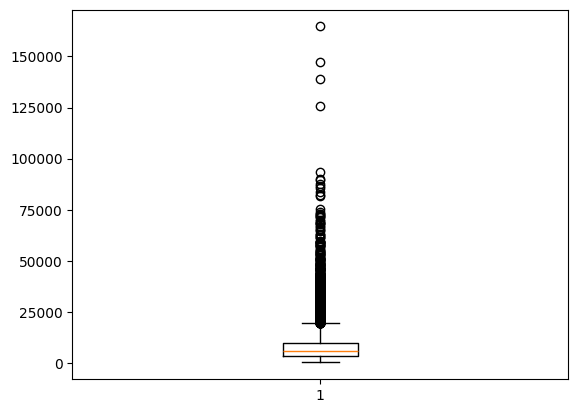

In [43]:
plt.boxplot(df[('Gastos_variables')])
plt.show()

In [26]:
# Evaluar el modelo en entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R² en entrenamiento y prueba
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# MAE en entrenamiento y prueba
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Resultados
print(f"R² en entrenamiento: {r2_train:.2f}")
print(f"R² en prueba: {r2_test:.2f}")
print(f"MAE en entrenamiento: {mae_train:.2f}")
print(f"MAE en prueba: {mae_test:.2f}")


R² en entrenamiento: 0.99
R² en prueba: 0.87
MAE en entrenamiento: 310.59
MAE en prueba: 904.30


In [27]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # Cambia 'r2' a 'neg_mean_absolute_error' si prefieres MAE

# Resultados de validación cruzada
print("R² en validación cruzada para cada partición:", cv_scores)
print(f"R² promedio en validación cruzada: {np.mean(cv_scores):.2f}")


R² en validación cruzada para cada partición: [0.91272727 0.9235381  0.932575   0.8882829  0.93489791]
R² promedio en validación cruzada: 0.92


In [ ]:
# Modelo con hiperparámetros ajustados
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Entrenar el modelo ajustado
model.fit(X_train, y_train)
